In [1]:
import os, sys
sys.path.append(os.path.abspath('../utils'))
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import dca_fs_tools as dcat
import dca_fs as dcafs
import pickle

# Difference between log-loss and Mean Net-benefit loss

### Introduction

In the previous example [01_net_benefit_loss_function.ipynb](./01_net_benefit_loss_function.ipynb) we benchmarked our implementations of lgistic regression with either cross-entropy loss:

\begin{equation}
\left\{ ylog(p) +\left(1-y)log(1-p)\right) \right\}
\tag{1}
\end{equation}

or mean-net-benefit maximizing loss, as described in [the README file](../README.md):

\begin{equation}
-\left\{ yp +\left(1-y) (p+log(1-p)\right) \right\} 
\tag{2}
\end{equation}

We saw that on synthetic data for whcih logistic regression is well-specified, there was no difference between the results of these two loss functions. 

In this notebook we again fit the following models:

* scikit learn's logistic regression
* our pytorch implementation of logistic regression with cross-entropy loss
* our pytorch implementation of logistic regression with mean-net-benefit maximization loss.

But instead of fitting on "well specified LR" synthetic data set we fit on a the "Ill-specified LR" synthetic data set described in [00_synthetic_data_description.ipynb](./00_synthetic_data_description.ipynb).

This dataset has an asymetry between positives and negatives and we will see that the mean-net-benefit maximizing loss function results in models with higher mean-net-benefit compared to standard cross-entropy logistic regression models.

## Fit the models

In order to compare to standard logistic regression we employ sklearn's LR:

In [2]:
logreg = LogisticRegression(C=10**18)

We generate "Ill-specified LR" data, which includes heteroskedacity in the relationship between the log-odds and the true linear function of the independent variables:

In [3]:
n_sample = 100000
true_params = [1.7, 0.8, -0.4]

df_train_het, df_test_het, df_noisy_train_het, df_noisy_test_het, ind_var_names_het, n_features_het, true_coefs_het = \
    dcat.make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [1.7, 0.8, -0.4], true_bias=0.0, heteros=2.5) 

Fit the baseline sklearn LR:

In [4]:
logreg.fit(df_train_het[ind_var_names_het], df_train_het["y"])

LogisticRegression(C=1000000000000000000)

Fit our implementations of logistic regression with cross-entropy loss and also mean-net-benefit loss: 

In [5]:
my_log_loss_het_model = dcafs.lr_train(df_train_het, n_epochs=1000, learn_rate=  1.0, loss_fun = 'log')
my_mnb_loss_het_model = dcafs.lr_train(df_train_het, n_epochs=1000, learn_rate=  1.0, loss_fun = 'mnb')

Make predictions from the three models on the test set.

In [6]:
sklearn_het_pred = logreg.predict_proba(df_test_het.drop("y", axis = 1))
my_log_loss_het_pred = dcat.make_net_prediction(my_log_loss_het_model["net"], df_test_het)
my_mnb_loss_het_pred = dcat.make_net_prediction(my_mnb_loss_het_model["net"], df_test_het)

combined_het_predictions = pd.concat([
    pd.DataFrame(sklearn_het_pred[:,1], columns = ["sklearn"]),
    pd.DataFrame(my_log_loss_het_pred, columns = ["log"]),
    pd.DataFrame(my_mnb_loss_het_pred, columns = ["mnb"])],
    axis = 1
)

combined_het_predictions["delta_skl_log"] = combined_het_predictions["sklearn"]-combined_het_predictions["log"]
combined_het_predictions["delta_skl_mnb"] = combined_het_predictions["sklearn"]-combined_het_predictions["mnb"]


Compare the predictions from our implementation (both cross-entropy loss and mean-net-benefit maximising loss) by plotting the difference. We see a small difference in prediction between scikit learn and our cross-entropy logistic regression models, but there apears to be a significant difference with the mean-net-benefit maximizing logistic regression predictions: 

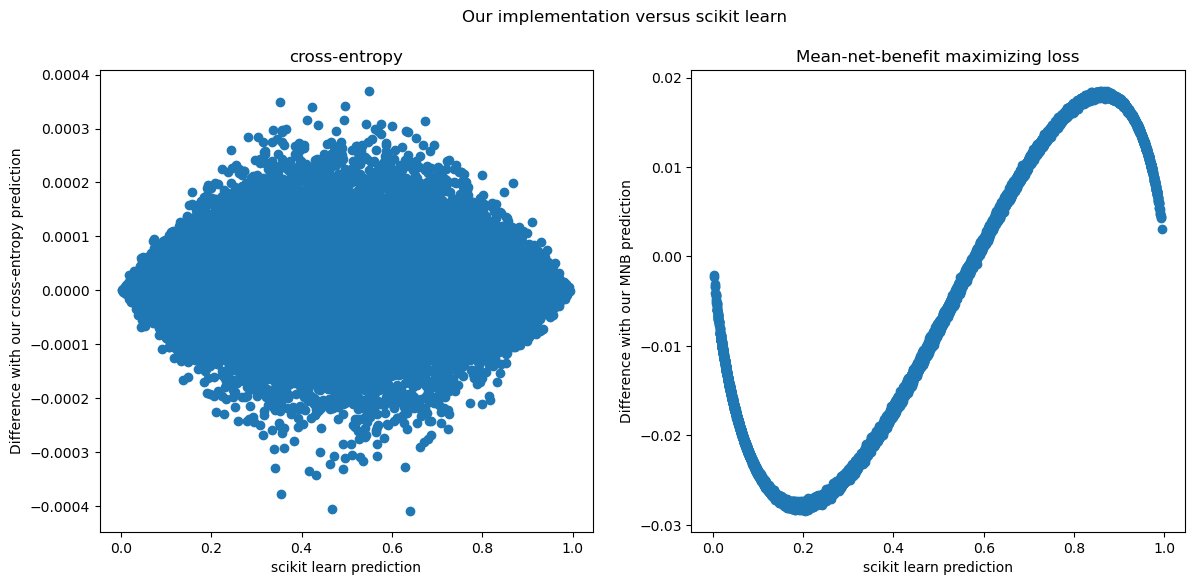

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14, 6))
fig.suptitle('Our implementation versus scikit learn')
ax1.scatter(combined_het_predictions["sklearn"], combined_het_predictions["delta_skl_log"])
ax2.scatter(combined_het_predictions["sklearn"], combined_het_predictions["delta_skl_mnb"])

ax1.set_xlabel("scikit learn prediction")
ax1.set_ylabel("Difference with our cross-entropy prediction")
ax1.set_title("cross-entropy")

ax2.set_xlabel("scikit learn prediction")
ax2.set_ylabel("Difference with our MNB prediction")
ax2.set_title("Mean-net-benefit maximizing loss")
fig.show()

Compare parameters

In [8]:

sklearn_het_params = logreg.coef_[0]
my_log_loss_het_params = my_log_loss_het_model['net'].linear.weight.detach().numpy()[0]
my_mnb_loss_het_params = my_mnb_loss_het_model['net'].linear.weight.detach().numpy()[0]

combined_het_params = pd.concat([
    pd.DataFrame(true_params, columns = ["True"]),
    pd.DataFrame(sklearn_het_params.transpose(), columns = ["sklearn"]),
    pd.DataFrame(my_log_loss_het_params.transpose(), columns = ["log"]),
    pd.DataFrame(my_mnb_loss_het_params.transpose(), columns = ["mnb"])
],
axis = 1)

combined_het_params

,True,sklearn,log,mnb
0,1.7,1.252238,1.252425,1.130978
1,0.8,0.622528,0.622342,0.563490
2,-0.4,-0.315203,-0.314869,-0.284890


In order to assess the comparison we take 300 bootstrap samples of the training set, and re-fit the models on each. We calculate both AUC and mean-net-benefit (MNB) on the held-out test set. 

In [9]:
# Set this variabe to decide whether to load the previously run picked version or recalculate
load_pickled_version = True

if load_pickled_version:
    with open('../data/benchmark-02.pkl', 'rb') as f:
        [skl_het_boot, torch_het_boot_log, torch_het_boot_mnb] = pickle.load(f)
else:
    n_bootstraps = 300

    skl_het_boot = []
    torch_het_boot_log = []
    torch_het_boot_mnb = []
    for i in range(3):
        for boot in range(n_bootstraps):
            #Make a bootstrap sample
            #-------------------------#
            df_boot_het = df_train_het.sample(frac=1, replace=True)

            #scikit learn
            #-------------
            skl_het_boot.append(dcat.lr_skl_boot(logreg, df_boot_het, df_test_het, label = i))

            # torch - log-loss
            #-------
            torch_het_boot_log.append(dcat.lr_boot(df_boot_het, df_test_het, loss_fun="log", label = i))

            # torch - mnb-loss
            #-------
            torch_het_boot_mnb.append(dcat.lr_boot(df_boot_het, df_test_het, loss_fun="mnb", label = i))

    skl_het_boot = pd.concat(skl_het_boot, axis = 0).reset_index().drop("index", axis=1)
    torch_het_boot_log = pd.concat(torch_het_boot_log, axis = 0).reset_index().drop("index", axis=1)
    torch_het_boot_mnb = pd.concat(torch_het_boot_mnb, axis = 0).reset_index().drop("index", axis=1)

    #with open('tmp.pkl', 'wb') as f:
    #    pickle.dump([skl_het_boot, torch_het_boot_log, torch_het_boot_mnb], f)


For each of the three models we plot the bootstrap distributions of the AUC and mean-net-benefit and also the parameter values.

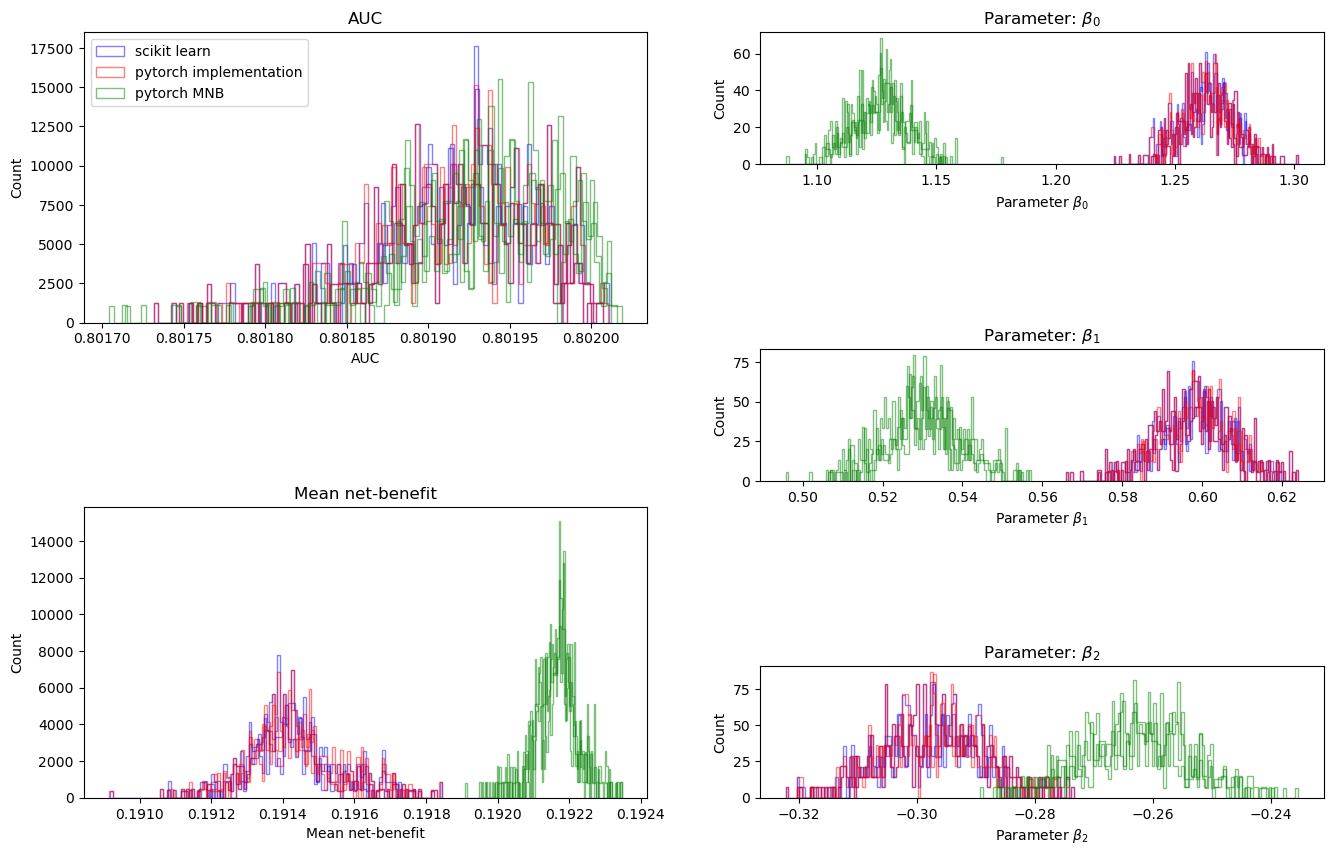

In [10]:
dcat.plot_bootstrap(skl_het_boot, torch_het_boot_log, torch_het_boot_mnb)

## Conclusion

We see that scikit learn and our implementation of cross-entropy logistic regression agree well as we would expect, and as occured in the [well-specified case](./01_net_benefit_loss_function.ipynb). However, in this "Ill-specified" case the mean-net-benefit maximizing logistic regression results is significantly larger mean-net benefit. This increase in mean-net-benefit seems not not come at the expense of performance measured by AUC as these are comparable between the three models. We note that the mean-net-benefit maximizing logistic regression also has significantly different model parameters compared to the standar logistic regression models.
 
